<a href="https://colab.research.google.com/github/poojamahajan0712/Data-Science-Portfolio/blob/main/Computer%20Vision/Hair%20Style%20Classification/Hair_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pwd

'/content'

In [ ]:
cd gdrive/MyDrive/HairClassification/data_new/

/content/gdrive/MyDrive/HairClassification/data_new


In [ ]:
import torch
from torchvision import datasets,transforms
import torch.utils.data as data
import os
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from torch.optim import SGD,Adam
#from torch_lr_finder import LRFinder


from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
import plotly.express as px
%matplotlib inline

In [ ]:
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


#The num_workers attribute tells the data loader instance how many sub-processes to use for data loading
num_workers = {'train_data' : 4 ,'test_data' : 0}

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1), #Randomly change the brightness, contrast and saturation of an image.
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5429, 0.4811, 0.4381],
                             [0.2954, 0.2953, 0.2958])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5429, 0.4811, 0.4381],
                             [0.2954, 0.2953, 0.2958])
    ])}

data_transforms = {'train_data':image_transforms['train'],'test_data':image_transforms['test']}

image_datasets = {x: datasets.ImageFolder(os.path.join(x),data_transforms[x])
                 for x in ['train_data', 'test_data']}

dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=num_workers[x])
                  for x in ['train_data', 'test_data']}


print('Length of training data',len(dataloaders['train_data'].dataset))
print('Length of test data ',len(dataloaders['test_data'].dataset))



CUDA Available? True
Length of training data 612
Length of test data  252


In [ ]:
# Labels of data
labels=image_datasets['train_data'].class_to_idx

id_label = {v: k for k, v in labels.items()}
print(id_label)

{0: 'braids', 1: 'curly', 2: 'dreadlocks', 3: 'kinky', 4: 'short-men', 5: 'straight', 6: 'wavy'}


Shape of data torch.Size([32, 3, 224, 224])


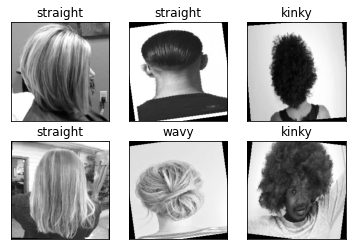

In [ ]:
#Loading one set of train data batch
sample = enumerate(dataloaders['train_data'])
batch_id, (sample_data, sample_targets) = next(sample)

#shape of one train data batch
print('Shape of data',sample_data.shape)

fig = plt.figure()
# Viewing 6 images from loaded train data batch
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample_data[i][0],cmap='gray')
    plt.title("{}".format(id_label[int(sample_targets[i])]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
model = models.resnet50(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.fc.in_features
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.Linear(256, 7))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)
summary(model, input_size=(3, 224, 224))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1,

In [ ]:
## list to hold loss and accuracy for train and test
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device,criterion, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):

            # get samples
            data, target = data.to(device), target.to(device)

            # Init
            optimizer.zero_grad()
            # Predict
            y_pred = model(data)

            # Calculate loss
            loss = criterion(y_pred, target)
            train_losses.append(loss)

            # Backpropagation
            loss.backward()
            optimizer.step()


            pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

            # Update pbar-tqdm
            pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
            train_acc.append(100*correct/processed)

def test(model, device,criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003,momentum=0.9)

EPOCHS = 40

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device,criterion, dataloaders['train_data'], optimizer, epoch)
    test(model, device,criterion, dataloaders['test_data'])

  0%|          | 0/20 [00:00<?, ?it/s]

cuda
EPOCH: 0


Loss=1.6425693035125732 Batch_id=19 Accuracy=18.46: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 104/252 (41.27%)

EPOCH: 1


Loss=1.230197548866272 Batch_id=19 Accuracy=54.41: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 181/252 (71.83%)

EPOCH: 2


Loss=1.4182478189468384 Batch_id=19 Accuracy=70.75: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 163/252 (64.68%)

EPOCH: 3


Loss=0.819750189781189 Batch_id=19 Accuracy=75.16: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 184/252 (73.02%)

EPOCH: 4


Loss=0.46806663274765015 Batch_id=19 Accuracy=79.74: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 186/252 (73.81%)

EPOCH: 5


Loss=0.9685108065605164 Batch_id=19 Accuracy=81.21: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 197/252 (78.17%)

EPOCH: 6


Loss=1.1704490184783936 Batch_id=19 Accuracy=81.86: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 195/252 (77.38%)

EPOCH: 7


Loss=0.996182382106781 Batch_id=19 Accuracy=84.80: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 193/252 (76.59%)

EPOCH: 8


Loss=0.9139478206634521 Batch_id=19 Accuracy=85.29: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 189/252 (75.00%)

EPOCH: 9


Loss=0.5342229008674622 Batch_id=19 Accuracy=84.31: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 206/252 (81.75%)

EPOCH: 10


Loss=0.47107622027397156 Batch_id=19 Accuracy=87.42: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 206/252 (81.75%)

EPOCH: 11


Loss=1.753814935684204 Batch_id=19 Accuracy=86.60: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 199/252 (78.97%)

EPOCH: 12


Loss=0.45909854769706726 Batch_id=19 Accuracy=87.42: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 186/252 (73.81%)

EPOCH: 13


Loss=0.7213969230651855 Batch_id=19 Accuracy=87.91: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 206/252 (81.75%)

EPOCH: 14


Loss=1.8402780294418335 Batch_id=19 Accuracy=86.60: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 196/252 (77.78%)

EPOCH: 15


Loss=0.5161499977111816 Batch_id=19 Accuracy=86.11: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 197/252 (78.17%)

EPOCH: 16


Loss=1.2367345094680786 Batch_id=19 Accuracy=88.89: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 206/252 (81.75%)

EPOCH: 17


Loss=1.0165098905563354 Batch_id=19 Accuracy=89.71: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 201/252 (79.76%)

EPOCH: 18


Loss=0.23789894580841064 Batch_id=19 Accuracy=89.05: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 202/252 (80.16%)

EPOCH: 19


Loss=1.353194236755371 Batch_id=19 Accuracy=90.36: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 207/252 (82.14%)

EPOCH: 20


Loss=0.5719031691551208 Batch_id=19 Accuracy=87.09: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 193/252 (76.59%)

EPOCH: 21


Loss=0.6470596194267273 Batch_id=19 Accuracy=87.75: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 191/252 (75.79%)

EPOCH: 22


Loss=0.36931633949279785 Batch_id=19 Accuracy=87.09: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 205/252 (81.35%)

EPOCH: 23


Loss=1.4350354671478271 Batch_id=19 Accuracy=89.71: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 204/252 (80.95%)

EPOCH: 24


Loss=4.7924370765686035 Batch_id=19 Accuracy=90.36: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 203/252 (80.56%)

EPOCH: 25


Loss=0.24002406001091003 Batch_id=19 Accuracy=84.97: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 196/252 (77.78%)

EPOCH: 26


Loss=0.23922061920166016 Batch_id=19 Accuracy=89.22: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 201/252 (79.76%)

EPOCH: 27


Loss=0.1596474051475525 Batch_id=19 Accuracy=92.48: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 208/252 (82.54%)

EPOCH: 28


Loss=0.17691433429718018 Batch_id=19 Accuracy=91.67: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 204/252 (80.95%)

EPOCH: 29


Loss=0.817583441734314 Batch_id=19 Accuracy=91.18: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 201/252 (79.76%)

EPOCH: 30


Loss=0.39480355381965637 Batch_id=19 Accuracy=89.71: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 205/252 (81.35%)

EPOCH: 31


Loss=0.17631877958774567 Batch_id=19 Accuracy=92.65: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 201/252 (79.76%)

EPOCH: 32


Loss=0.7555882930755615 Batch_id=19 Accuracy=92.16: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 207/252 (82.14%)

EPOCH: 33


Loss=0.379569947719574 Batch_id=19 Accuracy=92.97: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 202/252 (80.16%)

EPOCH: 34


Loss=3.010206937789917 Batch_id=19 Accuracy=88.89: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 200/252 (79.37%)

EPOCH: 35


Loss=0.4316037893295288 Batch_id=19 Accuracy=89.38: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 200/252 (79.37%)

EPOCH: 36


Loss=0.38271835446357727 Batch_id=19 Accuracy=90.69: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 197/252 (78.17%)

EPOCH: 37


Loss=1.4608714580535889 Batch_id=19 Accuracy=92.81: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 203/252 (80.56%)

EPOCH: 38


Loss=1.3777995109558105 Batch_id=19 Accuracy=90.36: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]
  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 193/252 (76.59%)

EPOCH: 39


Loss=0.8984857797622681 Batch_id=19 Accuracy=88.56: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]



Test set: Average loss: 0.0182, Accuracy: 205/252 (81.35%)

